In [1]:
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
#读入图片
image1 = mpimg.imread("./images/pa1.jpg")
image2 = mpimg.imread("./images/pa2.jpg")
images = [image1, image2]

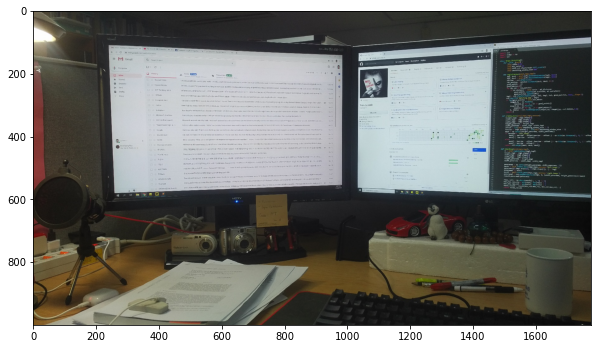

In [3]:
#举例显示image1
plt.figure(figsize=(10,10))
plt.imshow(image1)

In [4]:
sift = cv2.SIFT_create()#适用于OpenCV4.3
# 提取关键点和描述词
kp1, des1 = sift.detectAndCompute(image1, None)
kp2, des2 = sift.detectAndCompute(image2, None)

In [5]:
kp_image1 = cv2.drawKeypoints(image1, kp1, None)
kp_image2 = cv2.drawKeypoints(image2, kp2, None)

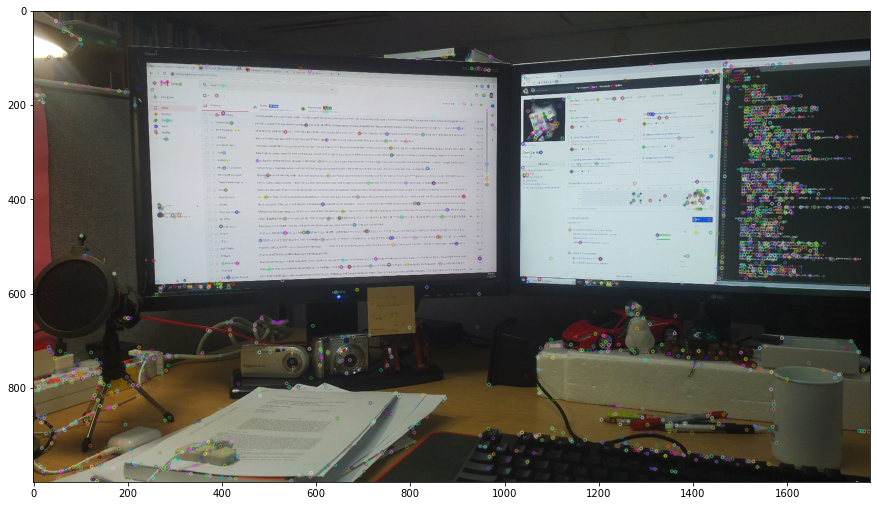

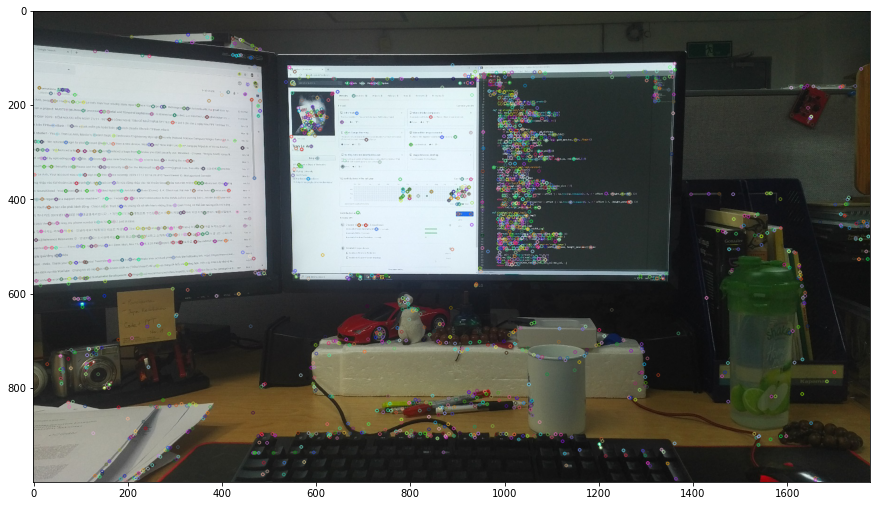

In [6]:
plt.figure(figsize=(15,10))
plt.imshow(kp_image1)
plt.figure(figsize=(15,10))
plt.imshow(kp_image2)

In [7]:
#特征匹配
ratio = 0.85
min_match = 10

matcher = cv2.BFMatcher()#Brute Force匹配法
raw_matches = matcher.knnMatch(des1, des2, k=2)
#两张图的特征向量匹配后得到一个集合
good_points = []
good_matches = []
for m1, m2 in raw_matches:
    if m1.distance < ratio * m2.distance:#接受匹配点的条件
        good_points.append((m1.trainIdx, m1.queryIdx))
        good_matches.append([m1])
matches = cv2.drawMatchesKnn(image1, kp1, image2, kp2, good_matches, None, flags=2)

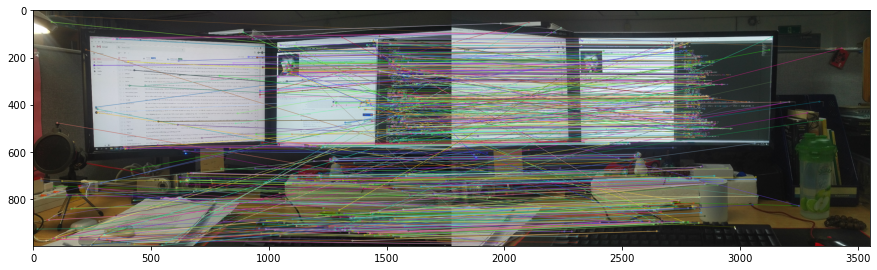

In [8]:
plt.figure(figsize=(15,10))
plt.imshow(matches)

In [9]:
# RANSAC
mask=[]
if len(good_points) > min_match:
    image1_kp = np.float32([kp1[i].pt for (_, i) in good_points])
    image2_kp = np.float32([kp2[i].pt for (i, _) in good_points])
    H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC, 5.0)    
#使用RANSAC方法计算单应性矩阵
    matchesMask = status.ravel().tolist()
    draw_params = dict(singlePointColor = None,
                   matchesMask = mask,
                   flags = 2)
    
matches2 = cv2.drawMatchesKnn(image1, kp1, image2, kp2, good_matches, None, **draw_params)

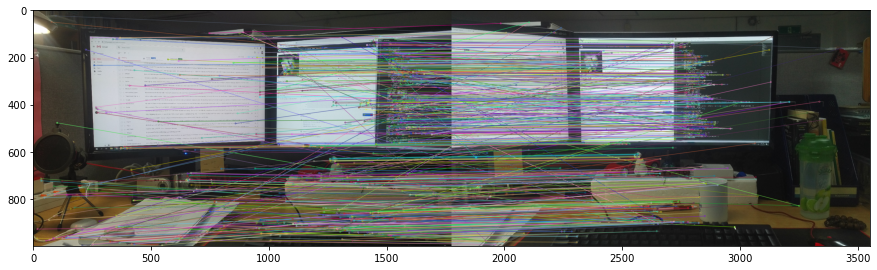

In [10]:
plt.figure(figsize=(15,10))
plt.imshow(matches)

In [11]:
#创建图像掩膜函数
def create_mask(img1,img2,version):
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 + width_img2
    offset = int(smoothing_window_size / 2)
    barrier = img1.shape[1] - int(smoothing_window_size / 2)
    mask = np.zeros((height_panorama, width_panorama))
    if version== 'left_image':
        mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
        mask[:, :barrier - offset] = 1
    else:
        mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
        mask[:, barrier + offset:] = 1
    return cv2.merge([mask, mask, mask])

In [12]:
smoothing_window_size = 800
height_img1 = image1.shape[0]
width_img1 = image1.shape[1]
width_img2 = image2.shape[1]
height_panorama = height_img1
width_panorama = width_img1 + width_img2

panorama1 = np.zeros((height_panorama, width_panorama, 3))
mask1 = create_mask(image1, image2, version='left_image')
panorama1[0:image1.shape[0], 0:image1.shape[1], :] = image1
panorama1 *= mask1
mask2 = create_mask(image1,image2,version='right_image')
panorama2 = cv2.warpPerspective(image2, H, (width_panorama, height_panorama))*mask2
result = panorama1 + panorama2

rows, cols = np.where(result[:, :, 0] != 0)
min_row, max_row = min(rows), max(rows) + 1
min_col, max_col = min(cols), max(cols) + 1
final_result = result[min_row:max_row, min_col:max_col, :]

In [13]:
#图像拼接
stitcher = cv2.createStitcher() if imutils.is_cv3() else cv2.Stitcher_create()
(status_1, stitched_1) = stitcher.stitch([image1, image2])

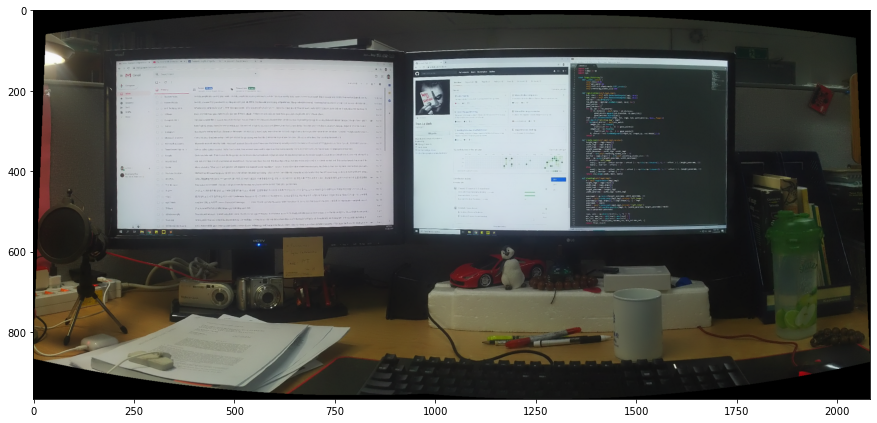

In [14]:
plt.figure(figsize=(15,10))
plt.imshow(stitched_1)